In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Importing Packages

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers
import tensorflow as tf

from losses import customLoss
from ploting import plotGeneratedImagesUNS, plotLossUNS
from saving import saveModels
from loadData import loadData

Using TensorFlow backend.


In [3]:
import warnings
#warnings.filterwarnings("ignore")

In [4]:
K.set_image_dim_ordering('th')

# Deterministic output.
# Tired of seeing the same results every time? Remove the line below.
np.random.seed(1000)

# The results are a little better when the dimensionality of the random vector is only 10.
# The dimensionality has been left at 100 for consistency with other GAN implementations.
randomDim = 20

In [5]:
# Load UNS Data
X_train, Y_train, X_test, Y_test = loadData(nrows=100000)

/home/peseux/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [6]:
X_train = X_train.values

In [7]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
generator = Sequential()
generator.add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(1024))
generator.add(LeakyReLU(0.2))
generator.add(Dense(10, activation='tanh'))
generator.compile(loss="binary_crossentropy", optimizer=adam)
# generator.compile(loss='binary_crossentropy', optimizer=adam)

In [9]:
discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=10, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(512))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

# Combined network
discriminator.trainable = False

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
lamda= .05
gan.compile(loss=customLoss(x, lamda), optimizer =adam)

In [11]:
dLosses = []
gLosses = []
def train(epochs=1, batchSize=128):
    batchCount = X_train.shape[0] / batchSize
    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batchCount))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

            # Generate fake MNIST images
            generatedImages = generator.predict(noise, verbose=False)
            # print np.shape(imageBatch), np.shape(generatedImages)
            X = np.concatenate([imageBatch, generatedImages])

            # Labels for generated and real data
            yDis = np.zeros(2*batchSize)
            # One-sided label smoothing
            yDis[:batchSize] = 0.9

            # Train discriminator
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(X, yDis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batchSize, randomDim])
            yGen = np.ones(batchSize)
            discriminator.trainable = False
            gloss = gan.train_on_batch(noise, yGen)

        # Store loss of most recent batch from this epoch
        dLosses.append(dloss)
        gLosses.append(gloss)


        if e == 1 or e % 20 == 0:
            pass
            #saveModels(e, generator=generator, discriminator=discriminator)
            #plotGeneratedImagesUNS(e, generator=generator, randomDim=randomDim)
    # Plot losses from every epoch
    plotLossUNS(e, dLosses, gLosses)

  0%|          | 0/558 [00:00<?, ?it/s]

Epochs: 10
Batch size: 128
Batches per epoch: 558.9453125
--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


  0%|          | 2/558 [00:00<00:51, 10.79it/s]

--------------- Epoch 2 ---------------


  0%|          | 2/558 [00:00<00:38, 14.50it/s]

--------------- Epoch 3 ---------------


  0%|          | 2/558 [00:00<00:39, 14.11it/s]

--------------- Epoch 4 ---------------


  0%|          | 2/558 [00:00<00:40, 13.56it/s]

--------------- Epoch 5 ---------------


  0%|          | 2/558 [00:00<00:39, 14.12it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/558 [00:00<00:38, 14.58it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/558 [00:00<00:40, 13.66it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/558 [00:00<00:40, 13.67it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/558 [00:00<00:37, 14.88it/s]

--------------- Epoch 10 ---------------


100%|██████████| 558/558 [00:39<00:00, 13.63it/s]


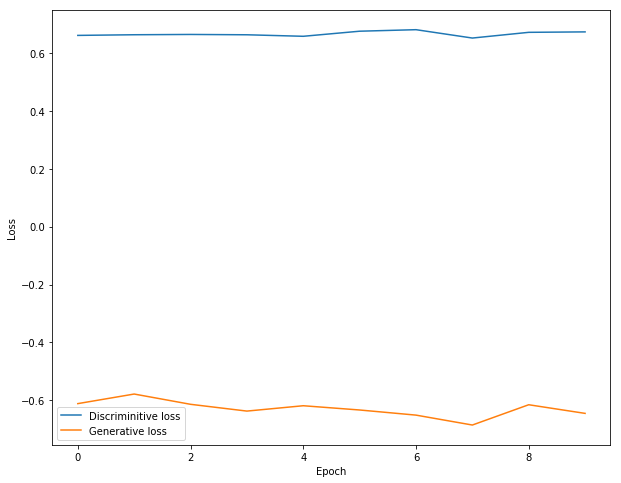

In [12]:
epochs = 10
batchSize = 128

train(epochs=epochs, batchSize=batchSize)

In [13]:
gan.get_weights()[0][0][0]

0.011332174